In [ ]:
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import re

In [ ]:
def load_fever_data(filename, n_lines=100):
    data = []
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if i >= n_lines:
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line}")
                print(e)
    return pd.DataFrame(data)

# Load 100 lines from each file
train_df = load_fever_data('train.jsonl', n_lines=10000)
valid_df = load_fever_data('dev.jsonl', n_lines=10000)
test_df = load_fever_data('test.jsonl', n_lines=10000)

# Display the first few rows to verify
print(train_df.head())
print(valid_df.head())
print(test_df.head())


       id      verifiable            label  \
0   75397      VERIFIABLE         SUPPORTS   
1  150448      VERIFIABLE         SUPPORTS   
2  214861      VERIFIABLE         SUPPORTS   
3  156709      VERIFIABLE          REFUTES   
4   83235  NOT VERIFIABLE  NOT ENOUGH INFO   

                                               claim  \
0  Nikolaj Coster-Waldau worked with the Fox Broa...   
1                 Roman Atwood is a content creator.   
2  History of art includes architecture, dance, s...   
3                  Adrienne Bailon is an accountant.   
4       System of a Down briefly disbanded in limbo.   

                                            evidence  
0  [[[92206, 104971, Nikolaj_Coster-Waldau, 7], [...  
1  [[[174271, 187498, Roman_Atwood, 1]], [[174271...  
2            [[[255136, 254645, History_of_art, 2]]]  
3           [[[180804, 193183, Adrienne_Bailon, 0]]]  
4                     [[[100277, None, None, None]]]  
       id      verifiable            label  \
0   91198 

In [ ]:
def load_fever_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line}")
                print(e)
    return pd.DataFrame(data)

train_df = load_fever_data('train.jsonl')
valid_df = load_fever_data('dev.jsonl')
test_df = load_fever_data('test.jsonl')

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


train_df['clean_claim'] = train_df['claim'].apply(preprocess_text)
valid_df['clean_claim'] = valid_df['claim'].apply(preprocess_text)
test_df['clean_claim'] = test_df['claim'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
valid_df['label'] = label_encoder.transform(valid_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

print("Label classes:", label_encoder.classes_)

Label classes: ['NOT ENOUGH INFO' 'REFUTES' 'SUPPORTS']


In [ ]:
# Tokenize the data
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = bert_tokenizer(list(train_df['clean_claim']), truncation=True, padding=True, max_length=128)
valid_encodings = bert_tokenizer(list(valid_df['clean_claim']), truncation=True, padding=True, max_length=128)
test_encodings = bert_tokenizer(list(test_df['clean_claim']), truncation=True, padding=True, max_length=128)

class FeverDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FeverDataset(train_encodings, train_df['label'].tolist())
valid_dataset = FeverDataset(valid_encodings, valid_df['label'].tolist())
test_dataset = FeverDataset(test_encodings, test_df['label'].tolist())

# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

# Trainer for BERT
bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

# Train the BERT model
bert_trainer.train()

# Evaluate the BERT model
bert_predictions = bert_trainer.predict(test_dataset)
bert_preds = bert_predictions.predictions.argmax(-1)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the data
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = roberta_tokenizer(list(train_df['clean_claim']), truncation=True, padding=True, max_length=128)
valid_encodings = roberta_tokenizer(list(valid_df['clean_claim']), truncation=True, padding=True, max_length=128)
test_encodings = roberta_tokenizer(list(test_df['clean_claim']), truncation=True, padding=True, max_length=128)

train_dataset = FeverDataset(train_encodings, train_df['label'].tolist())
valid_dataset = FeverDataset(valid_encodings, valid_df['label'].tolist())
test_dataset = FeverDataset(test_encodings, test_df['label'].tolist())

# Load RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Trainer for RoBERTa
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

# Train the RoBERTa model
roberta_trainer.train()

# Evaluate the RoBERTa model
roberta_predictions = roberta_trainer.predict(test_dataset)
roberta_preds = roberta_predictions.predictions.argmax(-1)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.643700,0.972074
2,0.724100,0.878959
3,0.628200,0.917674


In [ ]:
# Tokenize the data
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

train_encodings = xlnet_tokenizer(list(train_df['clean_claim']), truncation=True, padding=True, max_length=128)
valid_encodings = xlnet_tokenizer(list(valid_df['clean_claim']), truncation=True, padding=True, max_length=128)
test_encodings = xlnet_tokenizer(list(test_df['clean_claim']), truncation=True, padding=True, max_length=128)

train_dataset = FeverDataset(train_encodings, train_df['label'].tolist())
valid_dataset = FeverDataset(valid_encodings, valid_df['label'].tolist())
test_dataset = FeverDataset(test_encodings, test_df['label'].tolist())

# Load XLNet model
xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(label_encoder.classes_))

# Trainer for XLNet
xlnet_trainer = Trainer(
    model=xlnet_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

# Train the XLNet model
xlnet_trainer.train()

# Evaluate the XLNet model
xlnet_predictions = xlnet_trainer.predict(test_dataset)
xlnet_preds = xlnet_predictions.predictions.argmax(-1)


In [ ]:
# Calculate accuracy
bert_accuracy = accuracy_score(test_df['label'], bert_preds)
roberta_accuracy = accuracy_score(test_df['label'], roberta_preds)
xlnet_accuracy = accuracy_score(test_df['label'], xlnet_preds)

# Print classification reports
print("BERT Classification Report:\n", classification_report(test_df['label'], bert_preds, target_names=label_encoder.classes_))
print("RoBERTa Classification Report:\n", classification_report(test_df['label'], roberta_preds, target_names=label_encoder.classes_))
print("XLNet Classification Report:\n", classification_report(test_df['label'], xlnet_preds, target_names=label_encoder.classes_))


BERT Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.60      0.49      0.54      3333
        REFUTES       0.74      0.60      0.66      3333
       SUPPORTS       0.55      0.76      0.64      3333

       accuracy                           0.62      9999
      macro avg       0.63      0.62      0.61      9999
   weighted avg       0.63      0.62      0.61      9999

RoBERTa Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.59      0.41      0.49      3333
        REFUTES       0.74      0.56      0.63      3333
       SUPPORTS       0.51      0.79      0.62      3333

       accuracy                           0.59      9999
      macro avg       0.61      0.59      0.58      9999
   weighted avg       0.61      0.59      0.58      9999

XLNet Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.56      0.42      0.48 

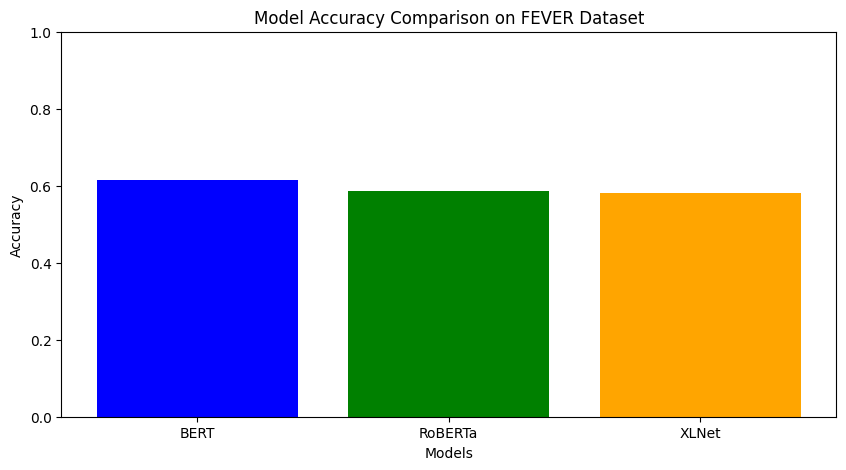

In [ ]:
# Plot accuracy comparison
models = ['BERT', 'RoBERTa', 'XLNet']
accuracies = [bert_accuracy, roberta_accuracy, xlnet_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim([0, 1])
plt.title('Model Accuracy Comparison on FEVER Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

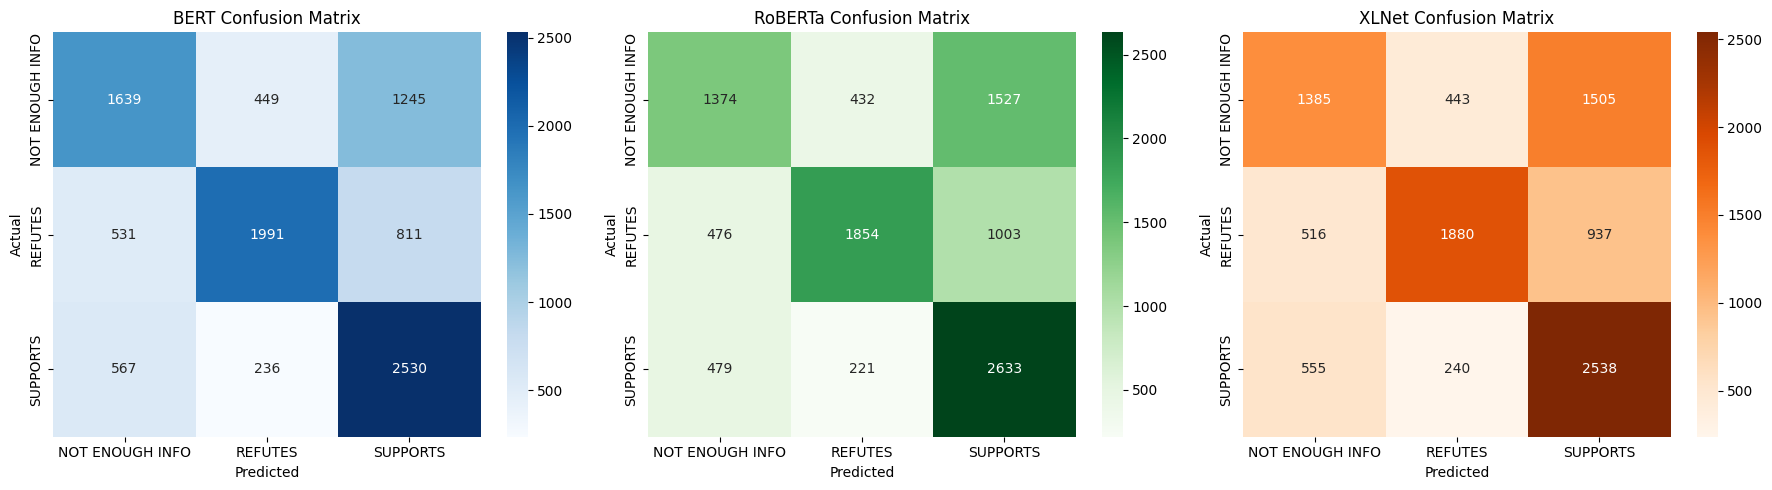

In [ ]:
# Plot confusion matrices
bert_cm = confusion_matrix(test_df['label'], bert_preds)
roberta_cm = confusion_matrix(test_df['label'], roberta_preds)
xlnet_cm = confusion_matrix(test_df['label'], xlnet_preds)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BERT
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('BERT Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# RoBERTa
sns.heatmap(roberta_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title('RoBERTa Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# XLNet
sns.heatmap(xlnet_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[2].set_title('XLNet Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()
